# Tutorial for SSVM-julia

In [1]:
using PyPlot, SSVM1slack  # Julia import of the libraries

The problem addressed here is presented in the slides of Dr Andrea Vedaldi, author of SVM-struct-matlab. It is a regression problem addressed with a SSVM; the basis functions chosen generate third-order polynomials

http://www.robots.ox.ac.uk/~vedaldi//assets/svm-struct-matlab/tutorial/ssvm-tutorial-handout.pdf, after slide 66.

### Problem function definitions

In [2]:
function lossCB(y, ybar)
  abs(ybar - y)
end

function featureCB(x, y)
  [y,
   y * x,
   y * x^2,
   y * x^3,
   - 0.5 * y^2]
end

function oracleCB(w, x, y)  # loss-augmented inference
  z = w[1] + w[2] * x + w[3] * x.^2 + w[4] * x.^3
    yhat = Float64[]
  if w[5] > 0
    yhat = [z - 1, z + 1] / w[5]
    yhat = max(min(yhat, 1),-1)
  end
    append!(yhat, [-1, 1])   
    augLoss = y_::Vector{Float64} -> abs(y_ - y) + z * y_ - 0.5 * y_.^2 * w[5]
  worse = indmax(augLoss(yhat))
    yhat = yhat[worse]
end

function oracleCB(w, x)    # inference
    z = w[1] + w[2] * x + w[3] * x.^2 + w[4] * x.^3
    y = z / w[5]
end

oracleCB (generic function with 2 methods)

###Data generation

In [3]:
x = collect(linspace(-pi,pi,21))
y = 0.5*sin(x)
y = y + 0.1*randn(size(y));
y_test = y + 0.1*randn(size(y));
xr = collect(linspace(minimum(x), maximum(x), 1024))
yr = collect(linspace(-1,1,1024));

### SVM-struct-julia parameters

In [4]:
param = Dict(
"X" => x,
"Y" => y,
"featureFn" => featureCB,
"lossFn" => lossCB,
"oracleFn" => oracleCB,
"c" => 1,
#"positivity" => [3],  # if one wants to enforce a positivity constraint on a coordinate of w
)

options = Dict(
"quadratic" => :primalqp,
"eps" => 0.001,
"num_passes" => 50,
"cachesize" => 10,
# "incremental" => [50., 80.],
"Xtest" => x,
"Ytest" => y_test,
"verbose" => 4
)

Dict{ASCIIString,Any} with 7 entries:
  "eps"        => 0.001
  "cachesize"  => 10
  "Ytest"      => [0.0108045,-0.186332,-0.445654,-0.477774,-0.507093,-0.592839,…
  "Xtest"      => [-3.14159,-2.82743,-2.51327,-2.19911,-1.88496,-1.5708,-1.2566…
  "verbose"    => 4
  "num_passes" => 50
  "quadratic"  => :primalqp

### Starting the SSVM

In [5]:
helper = Dict()
w = SSVM1slack.ssvm_1slack(param, options, helper);
print(helper["iterations"], " iterations; ", helper["inferences"], " augmented inferences")

[SSCM1slack] initializing Convex.jl problem
[SSCM1slack] begin learning...
[SSCM1slack] Iter 1: launching inference round (21/21 samples)...
[SSCM1slack] New violation 1.3070929241800666
[SSCM1slack] Solving quadratic problem... done! primal: 0.03446080051139313.
[SSCM1slack] Testing test set... done! mean test loss: 101.74365003564736
[SSCM1slack] Iter 2: launching inference round (21/21 samples)...
[SSCM1slack] New violation 2.675662960192059
[SSCM1slack] Solving quadratic problem... done! primal: 1.331212390409495.
[SSCM1slack] Testing test set... done! mean test loss: 0.7620110552811836
[SSCM1slack] Iter 3 cache violation 0.4392922153825746: using cache...
[SSCM1slack] Solving quadratic problem... done! primal: 1.6252879209166586.
[SSCM1slack] Testing test set... done! mean test loss: 1.6099734656380102
[SSCM1slack] Iter 4 cache violation 1.5052873936627231: using cache...
[SSCM1slack] Solving quadratic problem... done! primal: 2.156346997188879.
[SSCM1slack] Testing test set... do

### Results

In [45]:
w

5-element Array{Float64,1}:
 -0.0781337
  0.883285 
  0.0127014
 -0.0968913
  2.11064  

In [46]:
z = w[1] + w[2] * xr + w[3] * xr.^2 + w[4] * xr.^3;
F = yr*z' - 0.5 * yr.^2 * ones(size(z))' * w[5]; # scoring function
F_ = F .- maximum(F, 1); # column rescaled
y_fit = oracleCB(w, xr);

[SSCM1slack] Testing test set... done! mean test loss: 0.13583559070215112
[SSCM1slack] Iter 41 cache violation 0.002365528974611175: using cache...
[SSCM1slack] Solving quadratic problem... done! primal: 8.775080011692705.
[SSCM1slack] Testing test set... done! mean test loss: 0.13582516058456914
[SSCM1slack] Iter 42 cache violation 0.005871845485961591: using cache...
[SSCM1slack] Solving quadratic problem... done! primal: 8.789439165890538.
[SSCM1slack] Testing test set... done! mean test loss: 0.1412633843439354
[SSCM1slack] Iter 43 cache violation 0.0015365477748376932: using cache...
[SSCM1slack] Solving quadratic problem... done! primal: 8.792686315817305.
[SSCM1slack] Testing test set... done! mean test loss: 0.138013759759431
[SSCM1slack] Iter 44 cache violation 0.001792078654132001: using cache...
[SSCM1slack] Solving quadratic problem... done! primal: 8.793165752212792.
[SSCM1slack] Testing test set... done! mean test loss: 0.13606616115549897
[SSCM1slack] Iter 45 cache viol

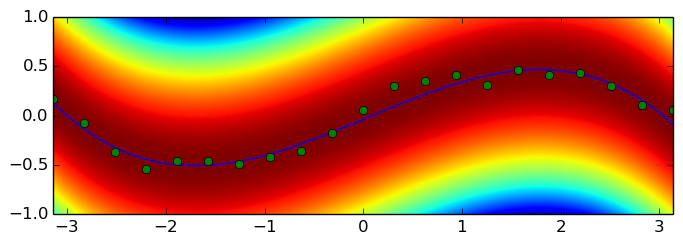

In [47]:
imshow(F_, extent=[minimum(x), maximum(x), -1, 1], origin="lower")
plot(xr, y_fit)
plot(x, y, "o")
xlim([minimum(x), maximum(x)]);

###Loss on the test set

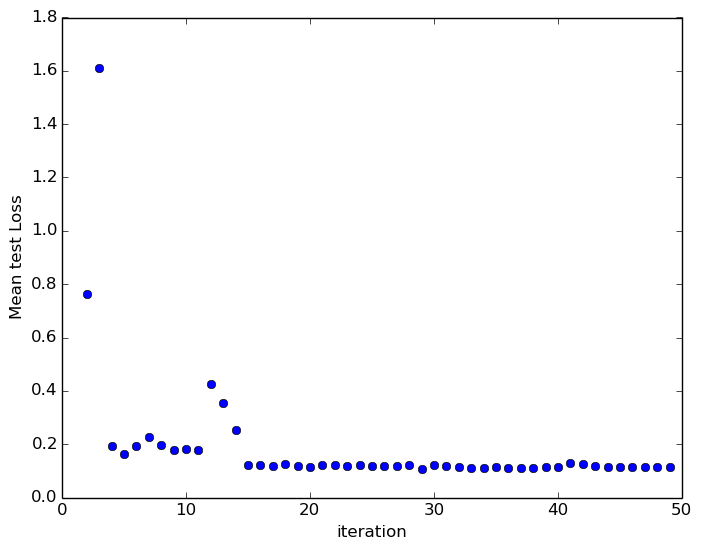

In [6]:
plot(helper["test_iter"][2:end], helper["test_loss"][2:end], "o")
xlabel("iteration")
ylabel("Mean test Loss");

###Time spent for solving the quadratic subproblems (uses warmstarting)

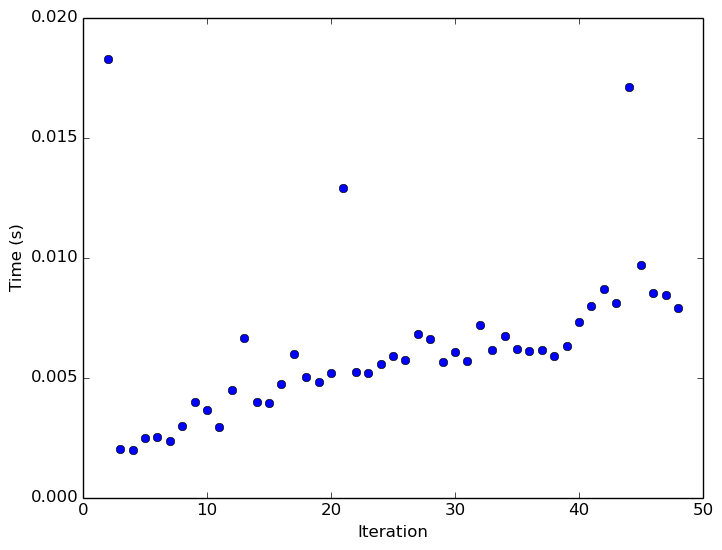

In [16]:
plot(2:helper["iterations"]-1, helper["time_quadratic"][2:end], "o") # first iteration is much longer, no warm-start
xlabel("Iteration")
ylabel("Time (s)");

### SSVM primal objective

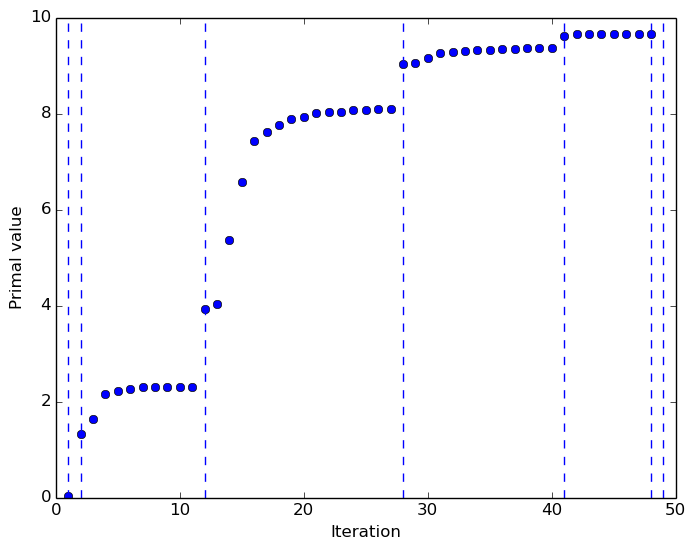

In [17]:
plot(1:helper["iterations"]-1, helper["primal"], "o")
for i in helper["inference_iter"]
    axvline(x=i, ls="--")
end
xlabel("Iteration")
ylabel("Primal value");

The vertical dashed lines represent the iterations where a full round of inference is done. The other iterations use constraint caching. One can see a jump in the primal objective when the cached constraints have been exhausted and the algorithm resorts to a new full inference.

### Comments

The current implementation solves the QP primal suproblem, making it easy to add new primal constraints, such as positivity constraints. The SSVM dual does not get computed; doing so could add a certificate of optimality in future improvements.

Current implementation has the following advantages over SVM-struct-matlab:
* Constraint caching (reuse full inference results)
* Parallellization of the inference step (one process per example)
* Additional positivity constraints on arbitrary coordinates of $w$

The two first points are very beneficial in settings were the inference task takes most of the time.